## **基于爬虫获取上海$2019 - 2022$年天气数据并可视化与简要分析**

- *姓名： 姜嘉祺*
- *学号：10225501447*

---
---
### **1. 获取数据**
#### 1.1 编写爬虫从网站获取数据

##### 以下是代号对应的区名：
- 71448：长宁；71450：普陀；71449：静安；71147：徐汇；
- 71451：虹口；71447：黄浦；71452：杨浦；71072：宝山；
- 60010：嘉定；60008：闵行；71146：浦东新区；60009：松江；
- 60007：青浦；60005：崇明；60298：奉贤；60006：金山；

In [3]:
import csv
import requests
import parsel
import datetime

district_mapping = {
    71448: '长宁', 71450: '普陀', 71449: '静安', 71147: '徐汇',
    71451: '虹口', 71447: '黄浦', 71452: '杨浦', 71072: '宝山',
    60010: '嘉定', 60008: '闵行', 71146: '浦东新区', 60009: '松江',
    60007: '青浦', 60005: '崇明', 60298: '奉贤', 60006: '金山',
}

with open('weather_data1_1.csv', 'w', newline='', encoding='utf-8') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['日期', '最高温度', '最低温度', '天气状况', '风向风力', '区域'])
    
    for district in district_mapping:
        for year in range(2019, 2023):
            for month in range(1, 13):
                url = f'https://tianqi.2345.com/Pc/GetHistory?areaInfo[areaId]={district}&areaInfo[areaType]=2&date[year]={year}&date[month]={month}'
                response = requests.get(url=url)
                response.encoding = 'utf-8'
                select = parsel.Selector(response.json()['data'])
                trs = select.css('table tr')
                
                for tr in trs[1:]:
                    tds = tr.css('td::text').getall()

                    date = tds[0].split()[0]  # 提取日期
                    high_temp = tds[1].strip('°')  # 提取最高温度
                    low_temp = tds[2].strip('°')  # 提取最低温度
                    weather_condition = tds[3]  # 提取天气状况
                    wind_info = tds[4]  # 提取风向风力

                    # 将数据写入CSV文件，使用代号对应的区域名
                    csv_writer.writerow([date, high_temp, low_temp, weather_condition, wind_info, district_mapping[district]])


---
#### 1.2 抽样查看样本数据

In [4]:
import pandas as pd

data = pd.read_csv('weather_data1_1.csv')
data.sample(5)

,日期,最高温度,最低温度,天气状况,风向风力,区域
8984,2019-08-07,34,27,多云~阴,东南风3级,杨浦
22482,2020-07-21,33,26,阴,东南风1级,金山
608,2020-08-31,34,27,晴~多云,东风3级,长宁
8232,2021-07-16,32,27,阴,东南风3级,黄浦
16218,2019-05-28,26,16,多云~阴,东北风3级,松江


---
#### 1.3 查看数据表结构信息

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23376 entries, 0 to 23375
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   日期      23376 non-null  object
 1   最高温度    23376 non-null  int64 
 2   最低温度    23376 non-null  int64 
 3   天气状况    23376 non-null  object
 4   风向风力    23376 non-null  object
 5   区域      23376 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


---
---
### **2. 数据处理**
#### 2.1 将日期一栏内容转换为日期格式

In [6]:
data['日期'] = pd.to_datetime(data['日期'])

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23376 entries, 0 to 23375
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日期      23376 non-null  datetime64[ns]
 1   最高温度    23376 non-null  int64         
 2   最低温度    23376 non-null  int64         
 3   天气状况    23376 non-null  object        
 4   风向风力    23376 non-null  object        
 5   区域      23376 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.1+ MB


---
#### 2.2 将风力风向数据进行切分、处理

In [8]:
import re
import numpy as np

df = pd.read_csv('weather_data1_1.csv')

# 定义解析风向风力文本的函数
def parse_wind(text):
    pattern = re.compile(r'([东南西北]+).*?(\d+)(?:-(\d+))?级')
    match = pattern.match(text)

    if match:
        wind_direction = match.group(1)
        wind_speed1 = int(match.group(2))
        wind_speed2 = int(match.group(3)) if match.group(3) else wind_speed1
        avg_wind_speed = np.mean([wind_speed1, wind_speed2])
        return wind_direction, avg_wind_speed
    else:
        return 0, 0

# 将函数应用于'风向风力'列，并创建新的列
df[['风向', '风力']] = df['风向风力'].apply(lambda x: pd.Series(parse_wind(x)))

# 填充NaN值为0
df[['风向', '风力']] = df[['风向', '风力']].fillna(0)

# 显示结果
df.sample(10)


,日期,最高温度,最低温度,天气状况,风向风力,区域,风向,风力
6521,2020-11-08,20,12,晴,东北风3级,虹口,东北,3.0
17274,2022-04-18,20,12,多云,东南风2级,松江,东南,2.0
9396,2020-09-22,25,20,阴,东北风2级,杨浦,东北,2.0
3664,2021-01-12,8,1,晴,西南风2级,静安,西南,2.0
11191,2021-08-22,31,26,阴,东南风2级,宝山,东南,2.0
5028,2020-10-07,22,18,阴~晴,东北风3级,徐汇,东北,3.0
6615,2021-02-10,12,9,阴~小雨,东南风2级,虹口,东南,2.0
16243,2019-06-22,29,19,多云,东北风2级,松江,东北,2.0
2800,2022-09-01,29,24,多云~阴,东北风3级,普陀,东北,3.0
18630,2022-01-03,14,0,多云,东南风1级,青浦,东南,1.0


---
#### 2.3 将年月日单独存储以便后续进行分析

In [9]:
df['日期'] = pd.to_datetime(df['日期'])

df['年'] = df['日期'].dt.year
df['月'] = df['日期'].dt.month
df['日'] = df['日期'].dt.day

df = df[['日期', '年', '月', '日', '最高温度', '最低温度', '天气状况', '风向风力', '风向', '风力', '区域']]

df.sample(10)

,日期,年,月,日,最高温度,最低温度,天气状况,风向风力,风向,风力,区域
5448,2021-12-01,2021,12,1,9,3,多云~晴,西北风3级,西北,3.0,徐汇
22805,2021-06-09,2021,6,9,29,23,阴,东南风3级,东南,3.0,金山
14423,2022-06-28,2022,6,28,34,26,多云~小雨,南风3级,南,3.0,闵行
9154,2020-01-24,2020,1,24,10,7,阴~小雨,东北风3级,东北,3.0,杨浦
4721,2019-12-05,2019,12,5,13,7,多云~小雨,东北风3级,东北,3.0,徐汇
6632,2021-02-27,2021,2,27,12,10,小雨,东北风3级,东北,3.0,虹口
21425,2021-08-29,2021,8,29,32,26,多云~阴,东南风3级,东南,3.0,奉贤
22754,2021-04-19,2021,4,19,19,11,晴,东南风微风,0,0.0,金山
4314,2022-10-24,2022,10,24,21,14,晴~阴,东北风3级,东北,3.0,静安
20094,2022-01-06,2022,1,6,8,4,多云~阴,东北风4级,东北,4.0,崇明


---
#### 2.4 将天气状况分成两栏，分别为开始和结束状态

In [10]:
df['开始状态'] = df['天气状况'].apply(lambda x: x.split('~')[0] if '~' in x else x)
df['结束状态'] = df['天气状况'].apply(lambda x: x.split('~')[-1] if '~' in x else x)

df = df[['日期', '年', '月', '日', '最高温度', '最低温度', '天气状况', '开始状态', '结束状态', '风向风力', '风向', '风力', '区域']]

df.sample(10)

,日期,年,月,日,最高温度,最低温度,天气状况,开始状态,结束状态,风向风力,风向,风力,区域
4254,2022-08-25,2022,8,25,34,26,多云~中雨,多云,中雨,东北风2级,东北,2.0,静安
3549,2020-09-19,2020,9,19,23,19,小雨~多云,小雨,多云,东北风2级,东北,2.0,静安
2435,2021-09-01,2021,9,1,37,27,多云~阴,多云,阴,东北风2级,东北,2.0,普陀
1651,2019-07-10,2019,7,10,27,22,小雨~阴,小雨,阴,东北风2级,东北,2.0,普陀
20180,2022-04-02,2022,4,2,14,2,多云~晴,多云,晴,东北风2级,东北,2.0,崇明
21220,2021-02-05,2021,2,5,10,6,阴~多云,阴,多云,东南风微风,0,0.0,奉贤
5556,2022-03-19,2022,3,19,13,7,雾~阴,雾,阴,北风3级,北,3.0,徐汇
2148,2020-11-18,2020,11,18,27,17,多云~小雨,多云,小雨,东南风4级,东南,4.0,普陀
17407,2022-08-29,2022,8,29,33,27,多云~阴,多云,阴,东南风3级,东南,3.0,松江
663,2020-10-25,2020,10,25,20,14,多云~晴,多云,晴,东南风2级,东南,2.0,长宁


In [11]:
# 查看 '开始状态' 与 '结束状态' 列的所有可能取值
unique_values = df['开始状态'].unique()
uvalues = df['结束状态'].unique()

print('开始状态',unique_values)
print('结束状态',uvalues)

开始状态 ['阴' '多云' '小雨' '晴' '雨夹雪' '中雨' '雷阵雨' '暴雨' '大雨' '大暴雨' '扬沙' '雾' '阵雨' '中雪']
结束状态 ['多云' '小雨' '阴' '晴' '中雨' '大雨' '暴雨' '雨夹雪' '小雪']


---
#### 2.5 根据上述状态制作天气状况转移表

In [12]:
transitions_table = pd.crosstab(df['开始状态'], df['结束状态'])
# 修改行的顺序
desired_order = ['晴', '多云', '阴', '小雨', '中雨', '大雨', '暴雨', '雨夹雪', '大暴雨', '阵雨', '雨夹雪', '中雪', '雾', '扬沙']
transitions_table = transitions_table.reindex(desired_order)
# 修改列的顺序
desired_order = ['晴', '多云', '阴', '小雨', '中雨', '大雨', '暴雨', '雨夹雪', '小雪']
transitions_table = transitions_table[desired_order]

# 显示透视表
transitions_table

结束状态,晴,多云,阴,小雨,中雨,大雨,暴雨,雨夹雪,小雪
开始状态,,,,,,,,,
晴,1566,768,312,122,2,0,0,0,0
多云,1690,3588,2174,1286,120,17,0,16,0
阴,502,1418,1584,1506,279,67,22,6,0
小雨,145,947,812,1655,265,72,15,44,5
中雨,15,69,145,474,108,73,17,0,0
大雨,3,18,49,138,76,36,22,1,0
暴雨,0,6,12,25,32,25,24,0,0
雨夹雪,11,8,0,13,1,0,0,8,0
大暴雨,0,2,1,1,2,10,8,0,0


---
---
### **3. 数据可视化**
#### 3.1 根据天气状况转移表绘制热力图

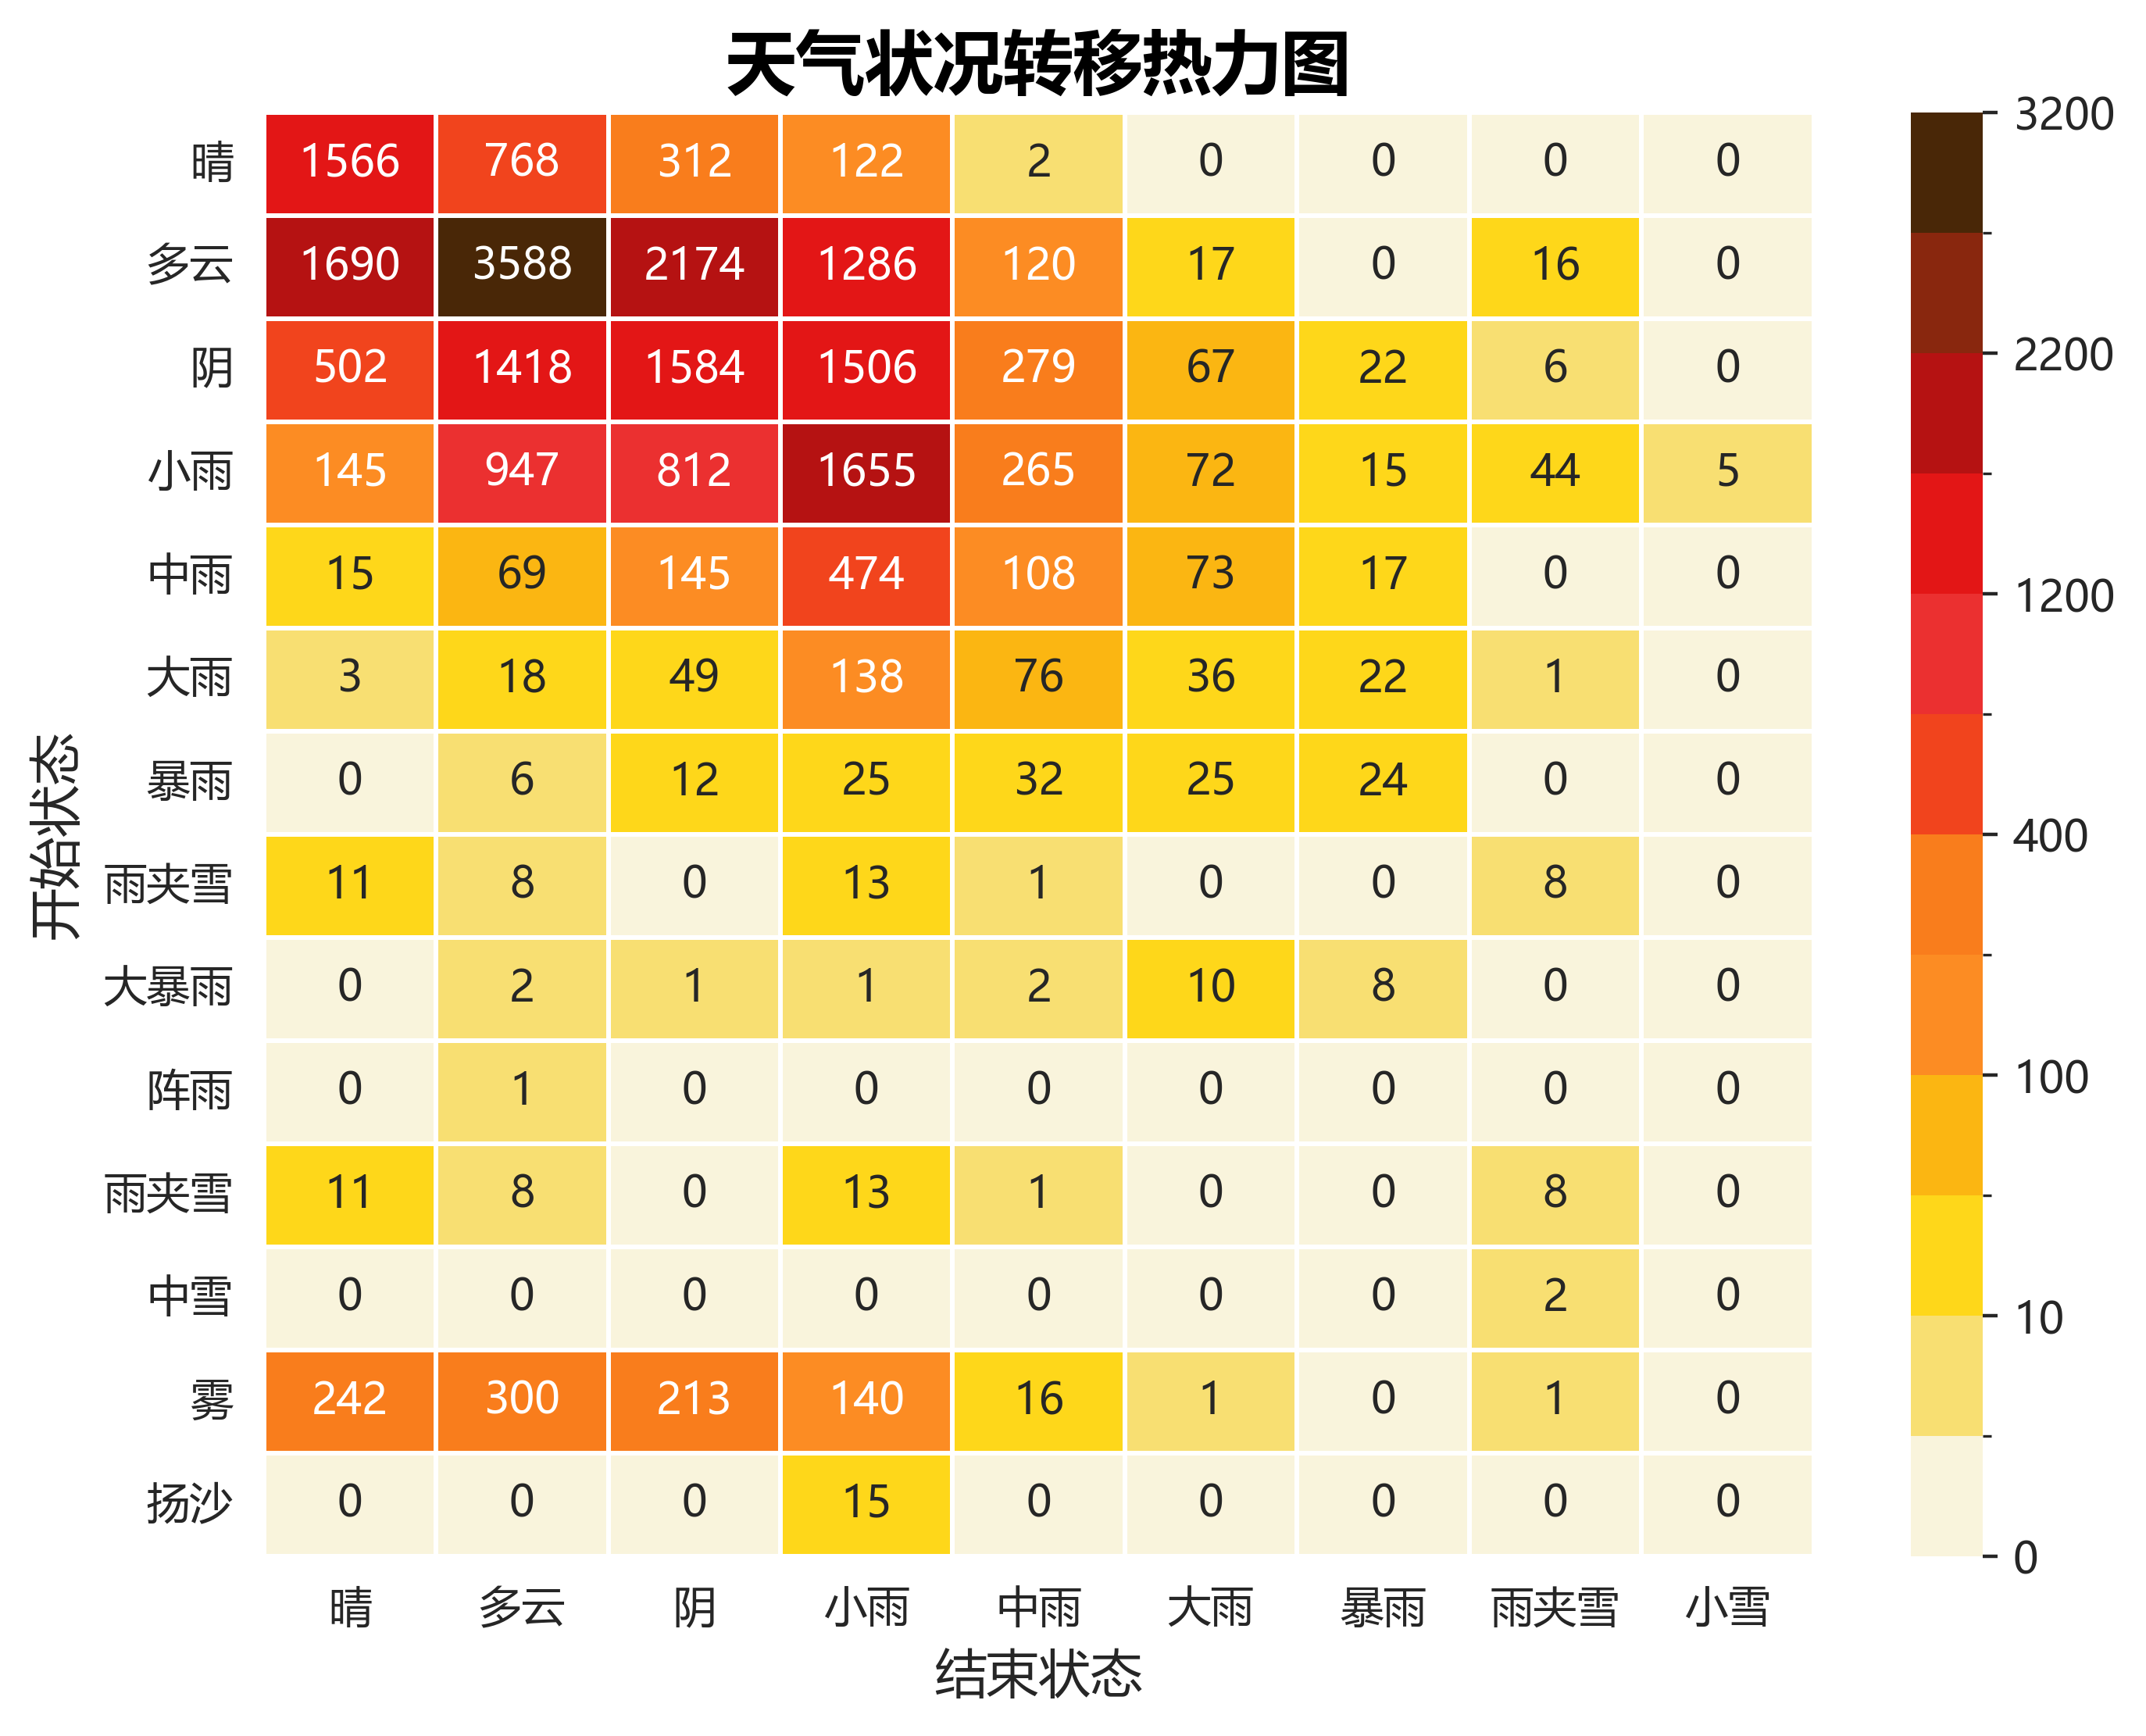

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns

# 设置全局默认字体为微软雅黑
plt.rcParams['font.family'] = ['Microsoft YaHei']

# 设置全局轴标签字体大小
plt.rcParams["axes.labelsize"] = 12

# 设置背景
sns.set_style("darkgrid", {"font.family": ['Microsoft YaHei', 'SimHei']})

# 设置画布长宽和dpi
plt.figure(figsize=(8, 6), dpi=400)

# 自定义颜色规则
color_dict = {0: '#F9F4DC', 1: '#F8DF72', 10: '#FED71A', 50: '#FBB612', 100: '#FC8C23',
              200: '#F97D1C', 400: '#F1441D', 800: '#EB3030', 1200: '#E31616',
              1600: '#B51212', 2200: '#89270E', 2800: '#6F200B', 3200: '#492707'}

# 提取颜色和取值
colors = list(color_dict.values())
values = list(color_dict.keys())

# 创建自定义色卡
cmap = ListedColormap(colors)
norm = BoundaryNorm(values, cmap.N, clip=True)

# 绘制热力图
ax = sns.heatmap(transitions_table, cmap=cmap, annot=True, linewidths=1, fmt='d', norm=norm)

# 单独设置标题文本的字体为黑体，大小为16
title_fontdict = {'fontsize': 16, 'fontweight': 'bold', 'color': 'black', 'fontname': 'Microsoft Yahei'}
plt.title('天气状况转移热力图', fontdict=title_fontdict)  # 图片标题文本和字体大小

plt.show()


#### **3.1.1 对上述转移表进行数据分析，我们可以得出初步结论：**

1. **最常见的开始状态：** 开始状态为**多云**的转移到各种天气状态的次数最多，其次是晴天。

2. **天气状态之间的转移：** **多云**、**阴**、**小雨**是相对比较平稳的天气状态，相互之间的转移较为频繁。大雨、暴雨等极端天气状态相对较少，而且更多地由小雨、中雨等状态转移到。

3. **转移稳定性：** **晴天**状态转移到其他天气状态的次数相较于其他有云的天气较低，说明晴天一般比较持久，不容易发生剧烈的天气变化。

4. **特殊天气数量：** 雾天和扬沙天气相对较少，且它们更多地转移到其他状态，而不是转移到自身，说明上海本身极端天气的数量较少，且不持久。

---
#### 3.2.1 汇总每个季节的风力风向数据

In [20]:
# 将日期转换为季节
df['日期'] = pd.to_datetime(df['日期'])
df['季节'] = df['日期'].dt.month.map({1: '冬季', 2: '冬季', 3: '春季', 4: '春季', 5: '春季', 6: '夏季', 7: '夏季', 8: '夏季', 9: '秋季', 10: '秋季', 11: '秋季', 12: '冬季'})

# 选择风向、风力以及季节这三列
wind_data_season = df[['风向', '风力', '季节']]

# 过滤掉风力为0的数据
wind_data_season = wind_data_season[wind_data_season['风力'] != 0]

# 创建透视表，计算每个季节每个风向的平均风速值
pivot_table_season = wind_data_season.pivot_table(index='风向', columns='季节', values='风力', aggfunc='mean')

# 按照风向、季节的顺序重新排列透视表的行列
desired_order = ['北', '东北', '东', '东南', '南', '西南', '西', '西北']
pivot_table_season = pivot_table_season.reindex(desired_order)
desired_order = ['春季', '夏季', '秋季', '冬季']
pivot_table_season = pivot_table_season[desired_order]

pivot_table_season

季节,春季,夏季,秋季,冬季
风向,,,,
北,2.752809,2.435484,2.983968,2.746753
东北,2.550966,2.529025,2.641064,2.557157
东,2.383178,2.603333,2.273312,2.256809
东南,2.740941,2.762269,2.500404,2.345349
南,2.418079,2.670611,2.593750,1.857143
西南,2.406321,2.507115,2.467391,2.351254
西,2.177419,2.407692,2.339286,2.041667
西北,2.783893,2.447761,3.022585,2.803958


#### 3.2.2 根据数据绘制风玫瑰图

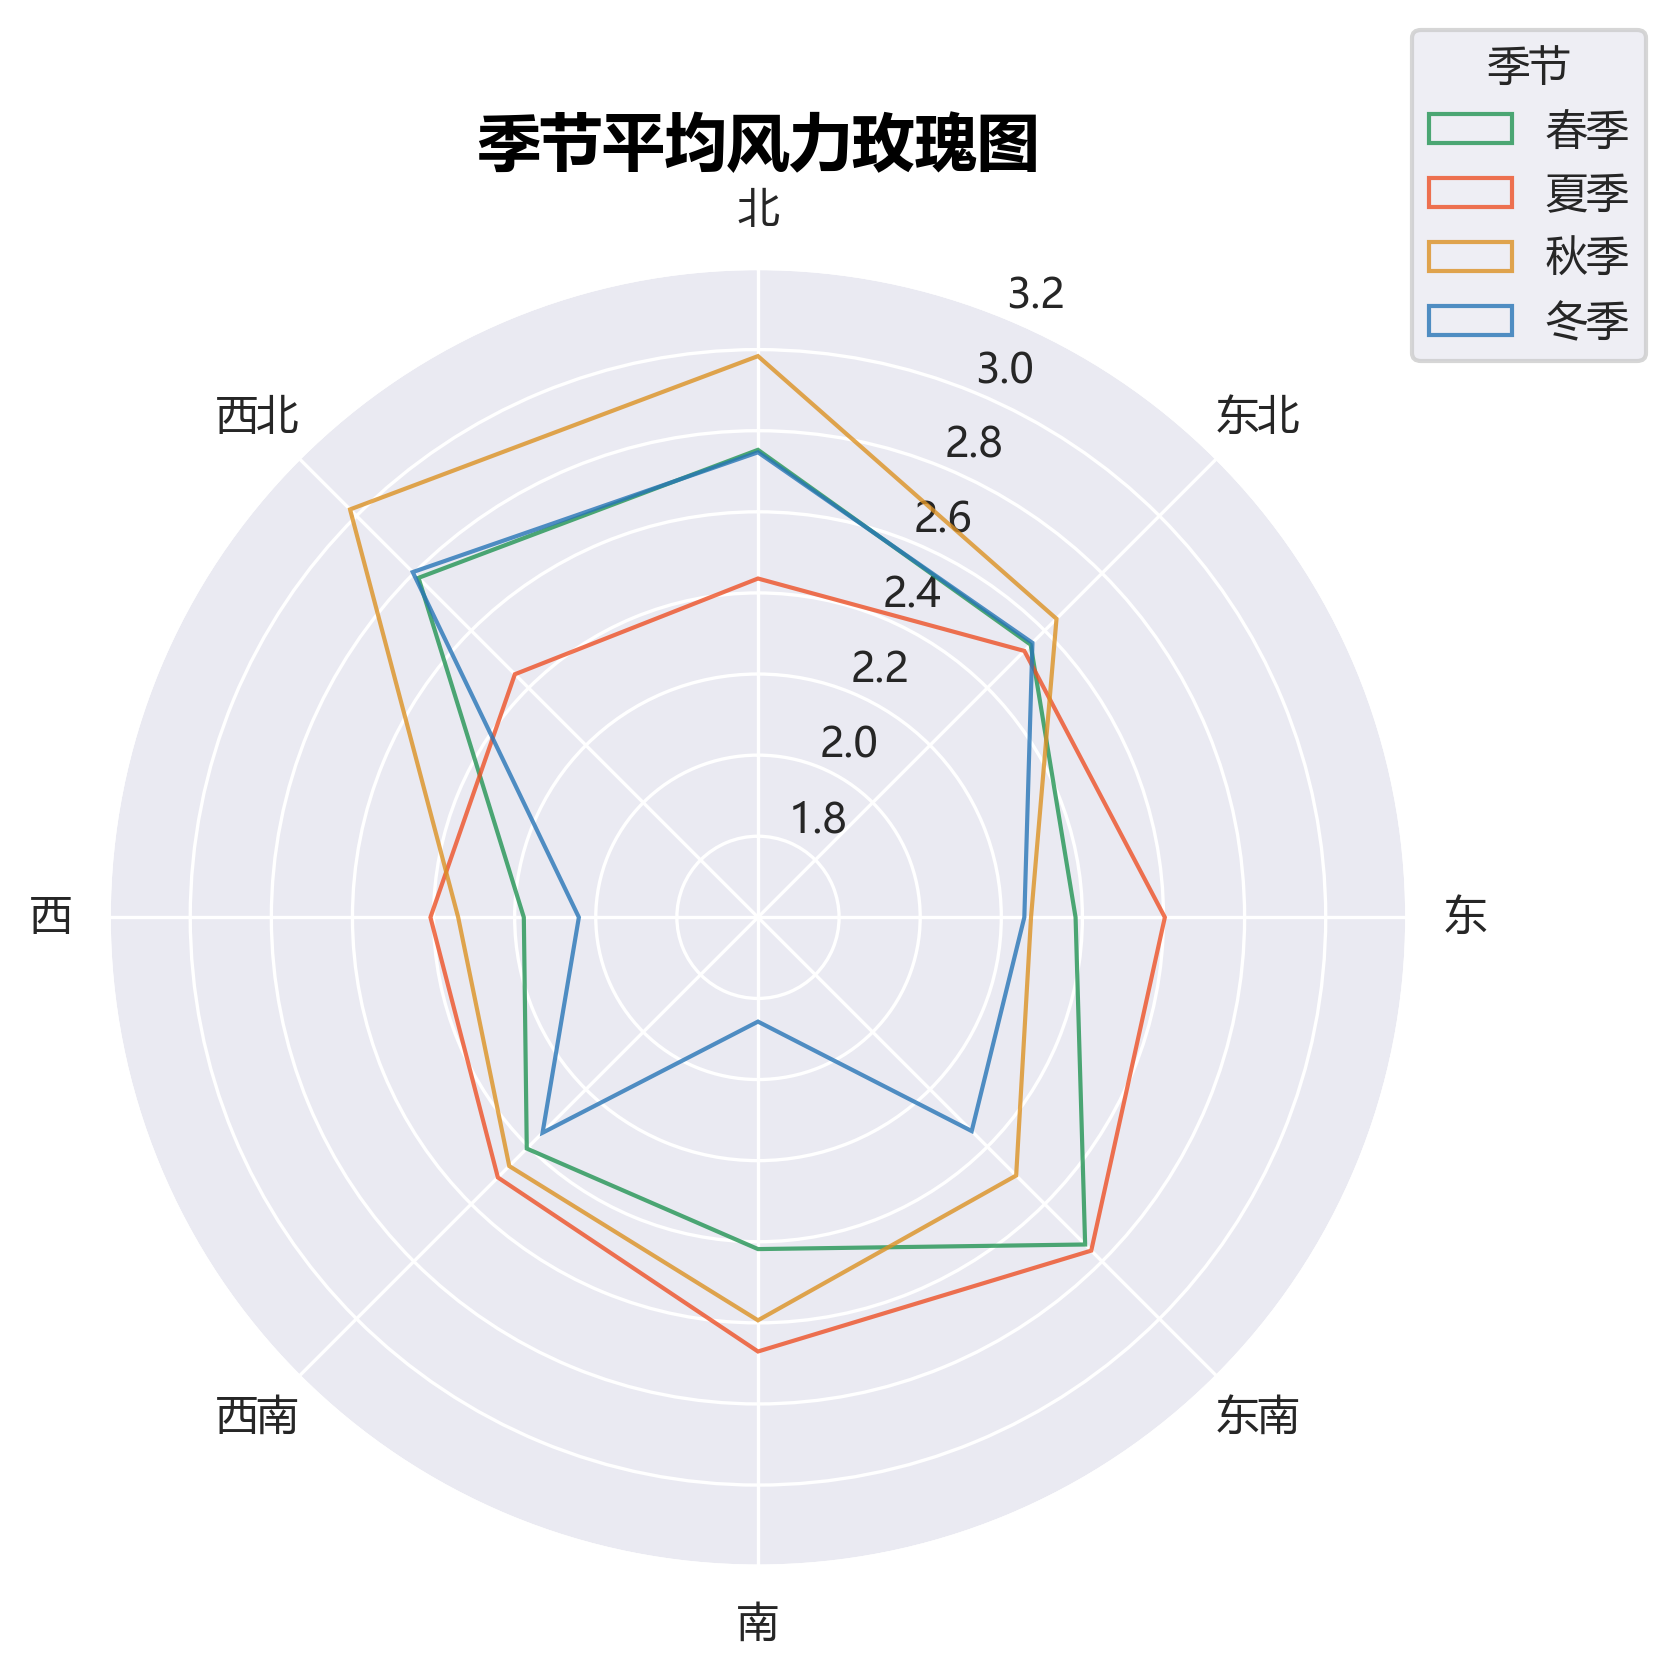

In [21]:
# 设置画布长宽和dpi
plt.figure(figsize=(10, 8), dpi=300)

# 风向的个数
N = len(pivot_table_season.index)
# 每个扇形的角度
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

# 循环每个季节
for i, (season, data) in enumerate(pivot_table_season.items()):
    # 自定义季节颜色
    if i == 0: # 春季
        seasoncolor = '#229453' # 孔雀绿
    elif i == 1: # 夏季
        seasoncolor = '#ED5126' # 朱红
    elif i == 2: # 秋季
        seasoncolor = '#DC9123' # 风帆黄
    elif i == 3: # 冬季
        seasoncolor = '#2775B6' # 景泰蓝
    # 风速数据
    radii = data.values
    # 创建一个极坐标子图
    ax = plt.subplot(1, 2, 2, polar=True, theta_direction=-1)
    # 绘制风玫瑰图
    ax.fill(np.concatenate((theta, [theta[0]])), np.concatenate((radii, [radii[0]])), label=season, alpha=0.8, edgecolor=seasoncolor, facecolor = 'none')
    # 添加每个风向的标签
    ax.set_xticks(theta)
    ax.set_xticklabels(pivot_table_season.index)
    # 设置0度位置为竖直向上
    ax.set_theta_zero_location('N')
    # 设置刻度范围
    ax.set_ylim(1.6, 3.2)
    # 设置标题
    ax.set_title('季节平均风力玫瑰图', fontsize=15, fontweight='bold', color='black', fontname='Microsoft YaHei')

# 添加图例到右上角
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2), title='季节')
# 添加整个图表的大标题
plt.tight_layout()
plt.show()

#### 3.2.3 **对上面的风玫瑰图进行简要分析，可以获取到如下的数据和结论：**

1. **春季（Spring）：**
   - 最强风向：西北风，平均风力 $2.784$ 级。
   - 最弱风向：西风，平均风力 $2.177$ 级。

2. **夏季（Summer）：**
   - 最强风向：东南风，平均风力 $2.762$ 级。
   - 最弱风向：西风，平均风力 $2.408$ 级。

3. **秋季（Autumn）：**
   - 最强风向：西北风，平均风力 $3.023$ 级。
   - 最弱风向：东风，平均风力 $2.273$ 级。

4. **冬季（Winter）：**
   - 最强风向：西北风，平均风力 $2.803$ 级。
   - 最弱风向：南风，平均风力 $1.857$ 级。

**同时，结合上海的地理位置，我们可以观察到以下趋势：**

- **春季：** 西北风相对较强，西风相对较弱，整体风向平均，可能与季节性气流和气候变化有关，表现为春季往往较快地回暖。
- **夏季：** 与春季数据相反，东南风成为最强风向，可能是由于季风的影响，夏季季风通常从海洋方向吹向陆地，西风也有所增强，但仍属于最弱。
- **秋季：** 西北风再次主导了最强风向，东风相对较弱，可能是受到气压系统和温度差异的季节性影响，内陆地区寒流频频南下，造成了这样的情况。
- **冬季：** 西北风仍较强，南风进一步减弱至一年中的最小值。这可能是受到冷空气的影响，从北方流向上海。整体上，冬季风向差异较大，可能受到多种气候系统的影响。

---
#### 3.3.1 各区每月最高最低气温统计

In [27]:
# 选择需要的列
df_temp = df[['年', '月', '日', '区域', '最高温度', '最低温度']]

# 计算平均温度
avg_temp = df_temp.groupby(['月', '区域']).agg({'最高温度': 'mean', '最低温度': 'mean'}).reset_index()
avg_temp.rename(columns={'最高温度': '平均最高气温', '最低温度': '平均最低气温'}, inplace=True)

# 计算最大和最小温度
temp_extremes = df_temp.groupby(['月', '区域']).agg({'最高温度': 'max', '最低温度': 'min'}).reset_index()

# 合并数据
avg_temp = pd.merge(avg_temp, temp_extremes, on=['月', '区域'], how='left')

# 检验结果
avg_temp

,月,区域,平均最高气温,平均最低气温,最高温度,最低温度
0,1,嘉定,9.032258,2.750000,22,-8
1,1,奉贤,9.362903,3.024194,22,-8
2,1,宝山,9.088710,3.072581,23,-7
3,1,崇明,8.774194,1.959677,22,-8
4,1,徐汇,9.177419,4.395161,21,-6
...,...,...,...,...,...,...
187,12,长宁,10.701613,5.193548,20,-5
188,12,闵行,11.459677,3.709677,20,-7
189,12,青浦,10.991935,2.459677,21,-8
190,12,静安,10.701613,5.193548,20,-5


---
#### 3.3.2 利用折线图可视化平均每月最高最低气温，散点图可视化每月最高最低气温极值

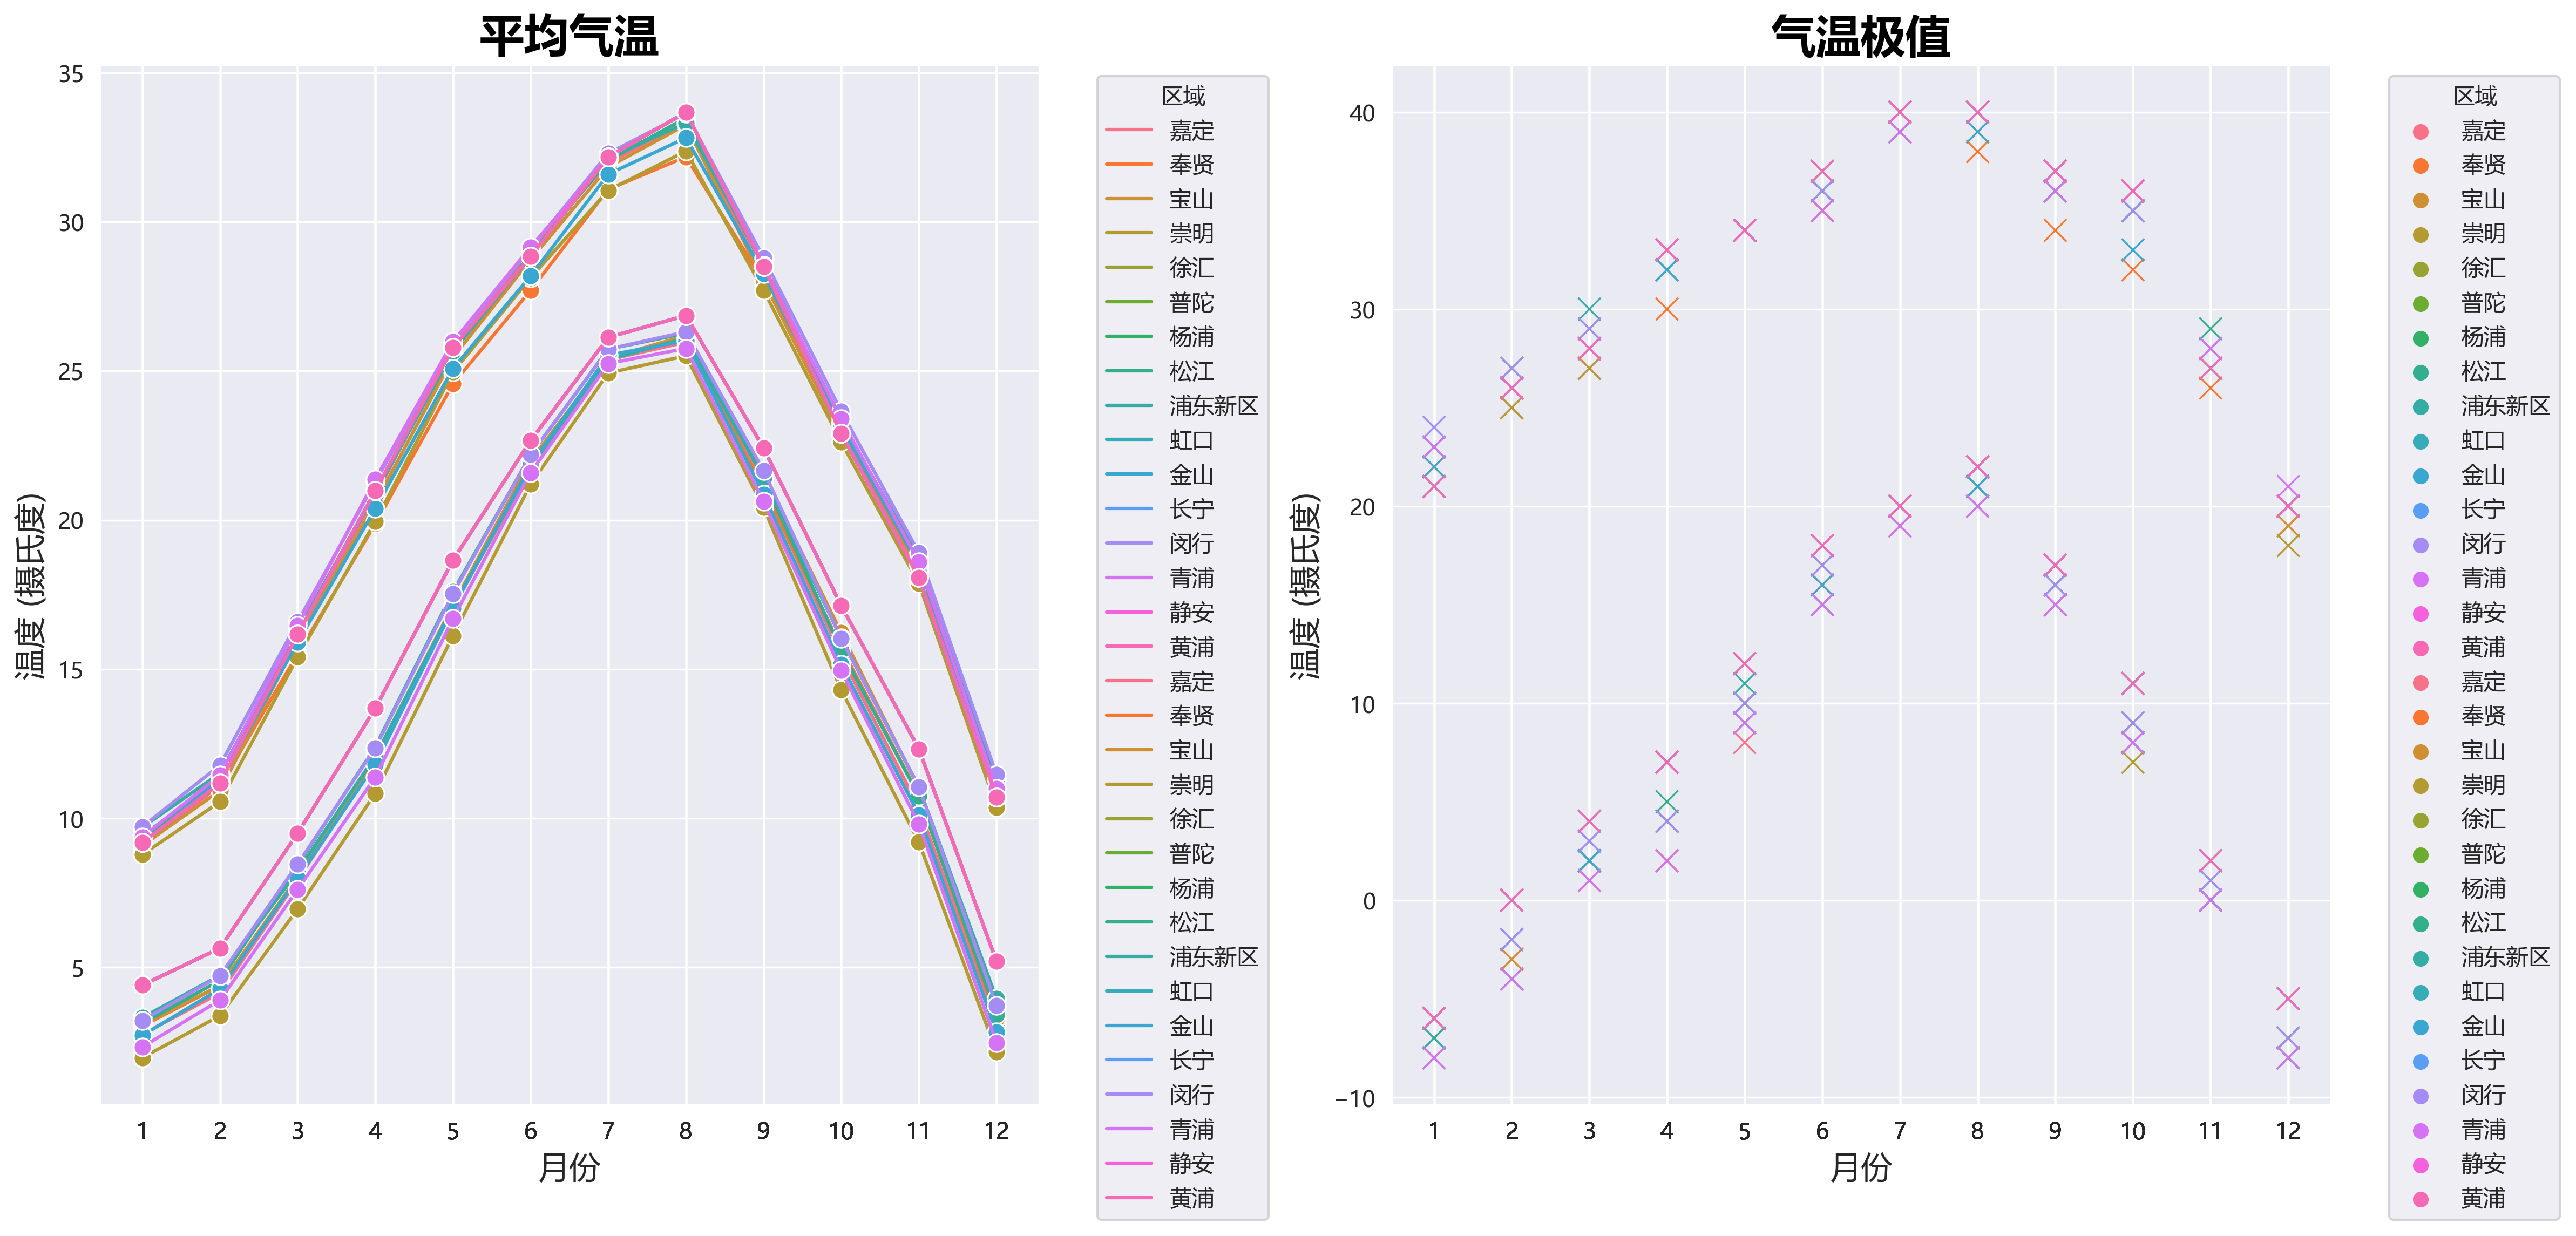

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图形大小
plt.figure(figsize=(16, 8), dpi=300)

# 创建第一个图表：平均气温
plt.subplot(1, 2, 1)
sns.lineplot(x='月', y='平均最高气温', hue='区域', data=avg_temp, marker='o', linestyle='-', markersize=8)
sns.lineplot(x='月', y='平均最低气温', hue='区域', data=avg_temp, marker='o', linestyle='-', markersize=8)
plt.title('平均气温', fontsize=20, fontweight='bold', color='black', fontname='Microsoft YaHei')
plt.xlabel('月份', fontsize=14)
plt.ylabel('温度 (摄氏度)', fontsize=14)
plt.legend(title='区域', bbox_to_anchor=(1.05, 1), loc='upper left')

# 设置x轴刻度
plt.xticks(avg_temp['月'])

# 创建第二个图表：气温极值
plt.subplot(1, 2, 2)
sns.scatterplot(x='月', y='最高温度', hue='区域', data=avg_temp, marker='x', s=100)
sns.scatterplot(x='月', y='最低温度', hue='区域', data=avg_temp, marker='x', s=100)
plt.title('气温极值', fontsize=20, fontweight='bold', color='black', fontname='Microsoft YaHei')
plt.xlabel('月份', fontsize=14)
plt.ylabel('温度 (摄氏度)', fontsize=14)
plt.legend(title='区域', bbox_to_anchor=(1.05, 1), loc='upper left')

# 设置x轴刻度
plt.xticks(avg_temp['月'])

plt.tight_layout()

plt.show()

---
#### 3.3.3 计算上述数据根据月份而划分的标准差

In [56]:
# 计算每月平均最高温度的标准差
std_avg_high_temp = avg_temp.groupby('月')['平均最高气温'].std().reset_index()
std_avg_high_temp.rename(columns={'平均最高气温': '平均最高气温标准差'}, inplace=True)

# 计算每月平均最低温度的标准差
std_avg_low_temp = avg_temp.groupby('月')['平均最低气温'].std().reset_index()
std_avg_low_temp.rename(columns={'平均最低气温': '平均最低气温标准差'}, inplace=True)

# 计算每月最高温度的标准差
std_max_temp = avg_temp.groupby('月')['最高温度'].std().reset_index()
std_max_temp.rename(columns={'最高温度': '最高温度标准差'}, inplace=True)

# 计算每月最低温度的标准差
std_min_temp = avg_temp.groupby('月')['最低温度'].std().reset_index()
std_min_temp.rename(columns={'最低温度': '最低温度标准差'}, inplace=True)

# 合并数据
std_temp = std_avg_high_temp.merge(std_avg_low_temp, on='月')
std_temp = std_temp.merge(std_max_temp, on='月')
std_temp = std_temp.merge(std_min_temp, on='月')

# 检验结果
std_temp

,月,平均最高气温标准差,平均最低气温标准差,最高温度标准差,最低温度标准差
0,1,0.231785,0.865602,0.997914,0.928709
1,2,0.262301,0.768513,0.680074,1.732051
2,3,0.299931,0.856358,0.774597,1.147461
3,4,0.417931,1.002377,0.806226,2.000000
4,5,0.392944,0.883110,0.000000,1.408309
5,6,0.392740,0.486026,0.834166,1.204159
6,7,0.385243,0.402916,0.478714,0.403113
7,8,0.489027,0.470185,0.602080,0.885061
8,9,0.273671,0.732506,0.813941,0.928709
9,10,0.251407,0.948817,1.195478,1.504161


#### 3.3.4 根据上述数据进行数据可视化

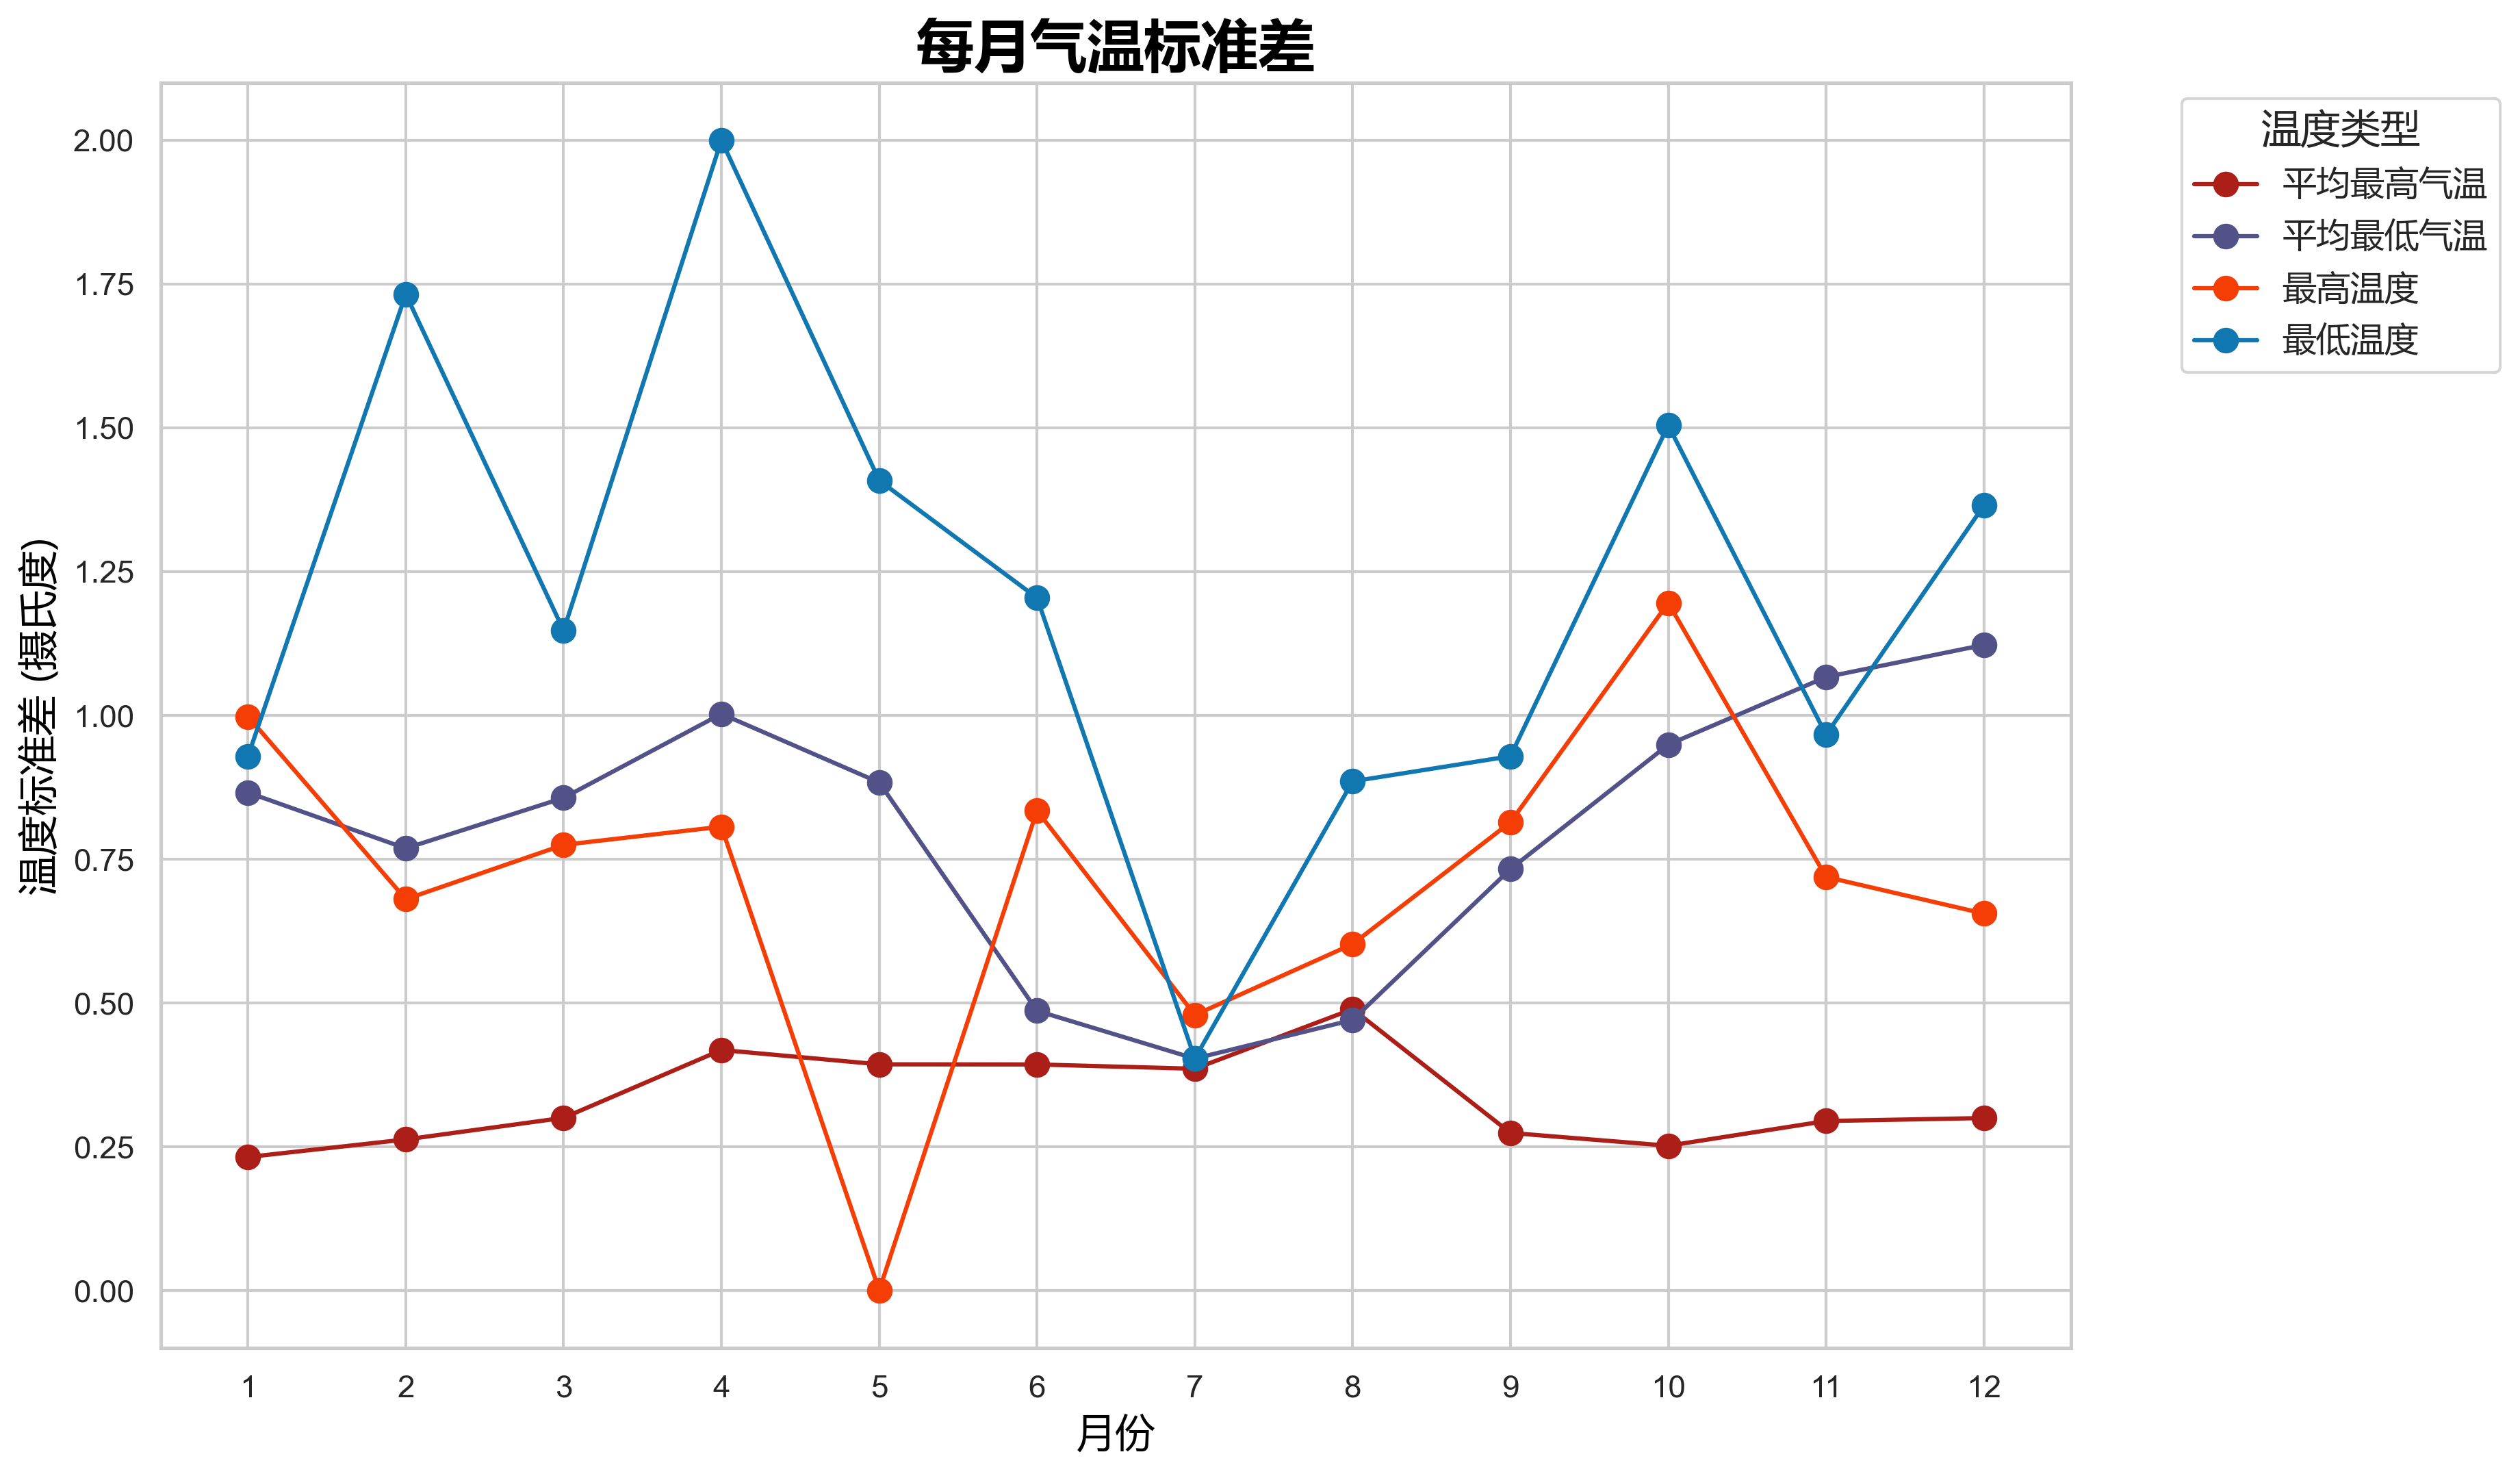

In [55]:
plt.figure(figsize=(12, 8), dpi=300)

# 设置中文显示
plt.rcParams['font.family'] = ['Microsoft YaHei']

# 创建图表
sns.set(style="whitegrid")

# 定义颜色和标签
colors = ['#AC1F18', '#525288', '#F43E06', '#1177B0']
labels = ['平均最高气温', '平均最低气温', '最高温度', '最低温度']

# 循环绘制每个数据列的图形
for i in range(4):
    plt.errorbar(x=std_temp['月'], y=std_temp.iloc[:, i + 1], label=labels[i], fmt='o-', markersize=8, color=colors[i])

# 设置标题和标签
plt.title('每月气温标准差', fontsize=20, fontweight='bold', color='black', fontname='Microsoft YaHei')
plt.xlabel('月份', fontsize=14, fontweight='normal', color='black', fontname='Microsoft YaHei')
plt.xticks(std_temp['月'])
plt.ylabel('温度标准差 (摄氏度)', fontsize=14, fontweight='normal', color='black', fontname='Microsoft YaHei')

# 设置图例字体
legend = plt.legend(title='温度类型', bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_title().set_fontsize(14)
legend.get_title().set_fontname('Microsoft YaHei')
legend.get_title().set_fontweight('normal')

for text in legend.get_texts():
    text.set_fontsize(12)
    text.set_fontname('Microsoft YaHei')

plt.show()

#### 3.3.5 整体趋势总结：

1. **平均最高气温标准差：**
   - 年度趋势：相对较小，整体稳定。
   - 季节趋势：各季节均相对稳定，无明显差别。
   - 说明上海各区一年的平均最高气温相差不多，表现为各区较为温和的体感，并不会感觉过于炎热。

2. **平均最低气温标准差：**
   - 年度趋势：相对较大，整体波动较前者明显。
   - 季节趋势：春季、冬季和秋季波动较大，夏季波动相对较小。
   - 说明上海各区在平均最低气温方面有着较大的差异，结合风频玫瑰图可以猜想，春秋冬三季主要由西北风主导，说明往往北方南下的寒流对区域最低气温影响较大。

3. **最高温度标准差：**
   - 年度趋势：整体波动较大，相对平均最低气温标准差而言变化更大。
   - 季节趋势：夏季波动较小，其余季节波动相对较大。
   - 说明符合上海所处地理位置，夏季由副热带高压控制，而春季各区回暖程度不同，秋季雨带北移造成各区温度差异，都会造成最高气温极值受到影响。

4. **最低温度标准差：**
   - 年度趋势：相对最大，整体波动明显。
   - 季节趋势：秋季到次年春季波动较大，夏季波动相对较小。
   - 说明自秋季开始，各区的最低温度就开始有了显著的差异，体现为郊区和市区的最低温差异明显，体感温度差异较大。

**总体来说，平均最高气温标准差整体较为稳定，而平均最低气温标准差和最低温度标准差整体波动较大。季节性的影响在气温标准差中表现较为明显，不同季节之间存在一定的差异，而最高气温的标准差普遍对应低于最低气温的标准差。**

---
---
### **4. 总结**
回首看这个项目，虽然看起来十分幼稚，但这也是我学习数据科学导论课程中的一个重要里程碑。通过这个项目，我不仅简要地通过自己的劳动，了解了上海的一部分气象数据，还学到了许多实用的数据科学分析的技能。

比如，我学会了如何获取实际场景中的数据，一点点根据蛛丝马迹调试，通过爬虫从网络上获取气象数据。这无疑锻炼了我的数据获取能力，并使我对数据的来源和质量有了更清晰的认识。

其次，通过使用 Python 编程语言和相关库，我进行了基础的数据清洗、处理和分析。在 Jupyter Notebook 中编写和运行代码的过程中，我更加熟悉了 Python 的语法和数据科学库，如 pandas、numpy 和 matplotlib 等。我不禁感叹工具的强大，为数据赋能的力量之大。这些都将为我在将来处理各种实际问题时提供坚实的基础。

在可视化方面，我通过绘制天气状况转移图、风力玫瑰图和气温趋势图等图表，提升了我的数据可视化技能。这不仅使我的分析结果更加直观、具备说服力，还为其他人更容易理解我的发现提供了有效的手段。

在解决问题的过程中，我学到了调试代码的能力，面对一行行的红色报错，一点点将其消除也是一件具有成就感的事情。这其中，我解决了一些数据处理和可视化中的问题。这锻炼了我的问题解决和调试能力，使我更加独立地面对数据科学项目。

最后，通过项目总结的文字，我将这个项目回顾了一遍，学会将复杂的数据科学概念以尽量清晰、简洁的方式传达给其他人。

总体来说，这个项目虽然简单，但给了我很多宝贵的经验和技能，是好是坏，这都是自己反复尝试的结果。它将会给我力量，为我后续的学习之路奠定了坚实的基础。